In [1]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as exo
import pymc3 as pm
import theano.tensor as T
import lightkurve as lk
import corner
from   seaborn import kdeplot

import sys
import os
import csv

from scipy import stats
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

from alderaan.constants import *
from alderaan import noise
from alderaan.utils import *

pi = np.pi

# Radius Valley experiment

In [2]:
N = 200

rE = (1.0, 1.4)
rN = (1.8, 2.2)

rp = np.hstack([np.random.uniform(rE[0], rE[1], N), np.random.uniform(rN[0], rN[1], N)])
rp_err = rp*np.random.normal(0, 1, N*2)

P = np.random.uniform(10,30,N*2)

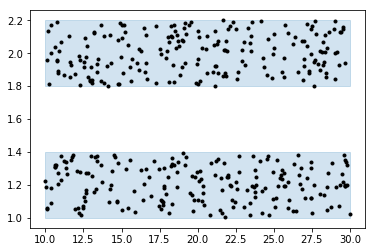

In [3]:
plt.figure()
plt.plot(P, rp, "k.")
plt.fill_between(np.linspace(10,30), rE[0], rE[1], alpha=0.2, color="C0")
plt.fill_between(np.linspace(10,30), rN[0], rN[1], alpha=0.2, color="C0")
plt.show()

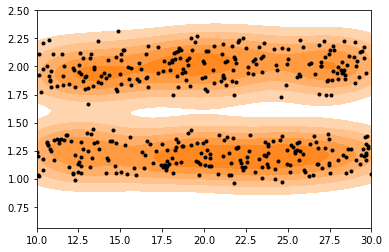

In [4]:
kdeplot(P, rp+rp_err*0.03, shade=True, shade_lowest=False, levels=5, clip=((10,30),(0.5,2.5)), color="C1");
plt.plot(P, rp+rp_err*0.03, "k.")

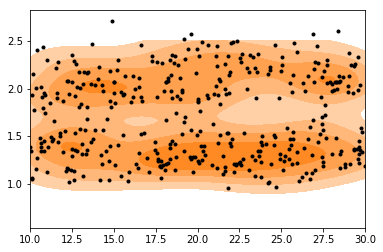

In [5]:
kdeplot(P, rp+rp_err*0.10 + 0.1, shade=True, shade_lowest=False, levels=5, clip=((10,30),(0.5,2.5)), color="C1");
plt.plot(P, rp+rp_err*0.10 + 0.1, "k.")

# Multi-dimensional Gaussian pairs plot

In [6]:
cov = np.random.uniform(0,1,size=16).reshape(4,4)
cov = cov + cov.T
cov[np.eye(4) == 1] = 3
cov /= cov.max()
cov = np.sqrt(cov)

samples = stats.multivariate_normal(cov = cov).rvs(4000)

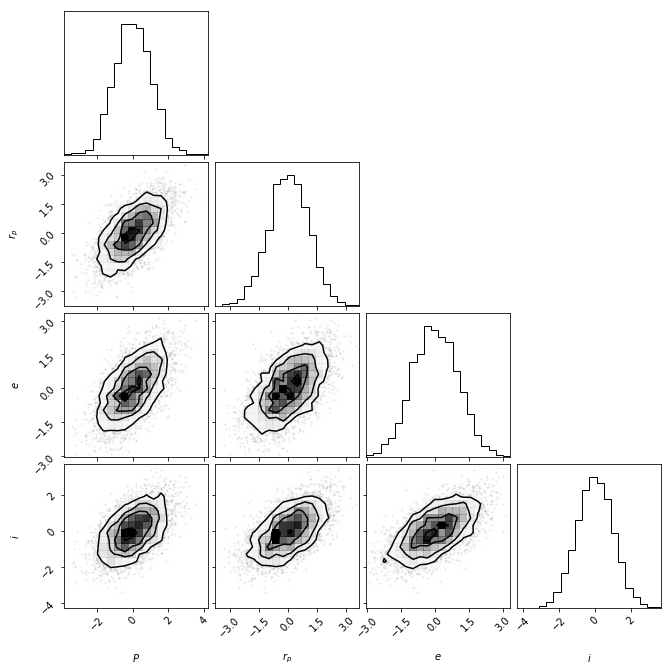

In [7]:
labels = ["$P$", "$r_p$", "$e$", "$i$"]

corner.corner(samples, labels=labels);

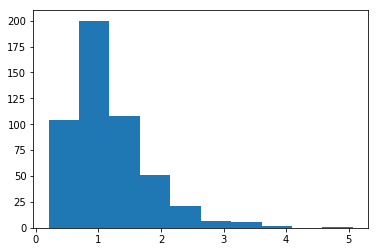

In [25]:
N = 500

per = stats.halfnorm(loc=0, scale=1).rvs(size=N)
rad = stats.loguniform(a=1, b=10).rvs(size=N)
ecc = stats.lognorm(0.5, loc=0, scale=1).rvs(size=N)
inc = stats.lognorm(0.5, loc=0, scale=1).rvs(size=N)

plt.hist(ecc);

In [14]:
stats.lognorm?

In [16]:
stats.loguniform?

# Some random population statistics stuff

In [ ]:
pE = 1265./2883
pN = 1618./2883

print(pE**3, pN**3)

# Matrices

In [ ]:
C = np.array([[1.0,0.5],
              [0.5,1.0]])

L = np.linalg.cholesky(C)
Linv = np.linalg.inv(L)

Linv

In [ ]:
-1/3*np.sqrt(3), 2/3*np.sqrt(3)

# Impact parameter re-parameterization

In [ ]:
r = 0.05
b = np.linspace(0,1+r, 1000)

b0 = 0.9
kb = 30

def phi_logistic(x, x0=b0, k=kb):
    return (pi/4)/(1+np.exp(-k*(x-x0)))

def phi_arctan(x, x0=b0, k=kb):
    return pi/8 + (1/4)*np.arctan(kb*(x-x0))


plt.figure()
plt.plot(b, phi_logistic(b), label="logistic")
plt.plot(b, phi_arctan(b), label="arctan")
plt.axhline(19.5*pi/180, color="r", ls="--")
plt.xlabel("b", fontsize=20)
plt.ylabel(r"$\phi$", fontsize=20)
plt.legend(fontsize=16)
plt.show()

In [ ]:
# using a fixed value phi = 22.5 deg
weights = np.array([np.sin(pi/8), np.cos(pi/8)])
weights /= np.sum(weights)

print(weights)

# CustomImpactParameter distribution

In [ ]:
import aesara_theano_fallback.tensor as tt
import numpy as np
import pymc3 as pm
from pymc3.distributions import draw_values, generate_samples

from exoplanet.distributions import transforms as tr

In [ ]:
class ImpactParameter(pm.Flat):
    """The impact parameter distribution for a transiting planet
    Args:
        ror: A scalar, tensor, or PyMC3 distribution representing the radius
            ratio between the planet and star. Conditioned on a value of
            ``ror``, this will be uniformly distributed between ``0`` and
            ``1+ror``.
    """

    def __init__(self, ror=None, **kwargs):
        if ror is None:
            raise ValueError("missing required parameter 'ror'")
        self.ror = tt.as_tensor_variable(ror)
        kwargs["transform"] = kwargs.pop(
            "transform", tr.ImpactParameterTransform(self.ror)
        )

        try:
            shape = kwargs.get("shape", self.ror.distribution.shape)
        except AttributeError:
            shape = None
        if shape is None:
            testval = 0.5
        else:
            testval = 0.5 + np.zeros(shape)
            kwargs["shape"] = shape
        kwargs["testval"] = kwargs.pop("testval", testval)

        super(ImpactParameter, self).__init__(**kwargs)

    def _random(self, ror=0.0, size=None):
        return np.random.uniform(0, 1 + ror, size)

    def random(self, point=None, size=None):
        (ror,) = draw_values([self.ror], point=point, size=size)
        return generate_samples(
            self._random,
            dist_shape=self.shape,
            broadcast_shape=self.shape,
            size=size,
        )

    def logp(self, value):
        return tt.zeros_like(tt.as_tensor_variable(value))


In [ ]:
# simulate some data
r_true = 0.0523
b_true = 0.3892
P_true = 29.12

t = np.arange(-0.3, 0.3, 0.002)

starrystar = exo.LimbDarkLightCurve([0.3,0.2])
orbit = exo.orbits.KeplerianOrbit(period=P_true, b=b_true)
light_curve = starrystar.get_light_curve(orbit, r=r_true, t=t)

f_true = pm.math.sum(light_curve, axis=-1).eval()
f = f_true + np.random.normal(size=len(f_true))*1e-3

plt.figure()
plt.plot(t, f, ".", c="lightgrey")
plt.plot(t, f_true, c="C0")
plt.show()

In [ ]:
# now try modeling it with my custom class
with pm.Model() as model:
    
    # model parameters
    log_ror = pm.Normal("log_ror", mu=np.log(0.05), sd=10)
    ror = pm.Deterministic("ror", T.exp(log_ror))
    
    b = ImpactParameter("beta", ror=ror)
    #b = pm.Deterministic("b", beta**2)
    
    T0 = pm.Normal("T0", mu=0, sd=0.1)
    
    # transit light curve
    starrystar = exo.LimbDarkLightCurve([0.3,0.2])
    orbit = exo.orbits.KeplerianOrbit(period=P_true, t0=T0, b=b)
    
    light_curve = starrystar.get_light_curve(orbit, r=ror, t=t)
    model_flux = pm.Deterministic("model_flux", pm.math.sum(light_curve, axis=-1))
    
    # likelihood
    obs = pm.Normal("obs", mu=model_flux, sd=1e-3*np.ones(len(f)), observed=f)

In [ ]:
with model:
    map_soln = pmx.sample(tune=500, draws=500, chains=2, target_accept=0.9)

### Kipping & Sandford 2016

In [ ]:
def prob_dbhat(b, r, rho=None, P=None):
    """
    Kipping & Sandford 2016 Eq. 34-36 & 28
    Assumes zero eccentricity
    
    Parameters
    ----------
        b : array-like
            impact parameters
        r : float
            planet-to-star radius ratio
        rho : float
            stellar density
        P : float
            orbital period
            
    Returns
    -------
        prob : array-like
    """
    x = (1+r)**2
    y = 0.5*(1+r)*(x - b**2)
    z = (1+r-b)/(2*r)
    
    eta = y**-0.25 * r**2 * (np.sqrt(x-b**2) + np.sqrt((1-r)**2-b**2))
    zeta = y**0.25 * 0.25*(1+r-b)**2 * (1 - 2*np.log(z)/np.log(4))
    
    
    if np.any(b) != 0:
        norm = prob_dbhat(0,r)
    else:
        norm = 1.0
        
        
    if (type(b) is float) or (type(b) is int):
        if b < 1-r:
            return eta/norm
        elif b < 1+r:
            return zeta/norm
        else:
            return 0.0

        
    elif type(b) is np.ndarray:
        prob = np.zeros(len(b))
        prob[b < 0] = np.nan
        prob[(0 <= b)*(b < 1-r)] = eta[(0 <= b)*(b < 1-r)]
        prob[(1-r <= b)*(b < 1+r)] = zeta[(1-r <= b)*(b < 1+r)]
        
        return prob/norm

In [ ]:
R = 0.5
r = 0.05
b = np.linspace(0,1+R,1000)

prob = prob_dbhat(b, R)
simple = (1-b**2)**0.25
simple[b > 1] = 0

w = np.ones(len(prob))

t = (b >= 1-r)*(b < 1)

w[t] = np.linspace(1,0,np.sum(t))
w[b >= 1] = 0

combo = w*simple + (1-w)*prob

combo = boxcar_smooth(combo, winsize=25)

#plt.plot(b, prob)
#plt.plot(b, simple)
plt.plot(b, combo)

# Interpolated lightcurves

In [ ]:
N = 12345

t = np.linspace(-1.2,1.2,N)

f = np.ones(N)
f[np.abs(t) < 1] = t[np.abs(t) < 1]**2

plt.figure(figsize=(12,4))
plt.plot(t, f, "k")
plt.show()

In [ ]:
spline = pm.distributions.dist_math.SplineWrapper(UnivariateSpline(t,f,s=0))

t_interp = np.linspace(-1.5,1.5,67)
f_interp = spline(t_interp).eval()

plt.figure(figsize=(8,3))
plt.plot(t, f, "k")
plt.plot(t_interp, f_interp, "r.")
plt.show()

In [ ]:
def interpolate(x0, y0, x):
    """
    Docstring
    """
    xmin, xmax = x.min(), x.max()
    
    x = np.array(x)
    dx = np.min(np.diff(x0))
    
    
    # pad the input arrays as needed (move this outside fxn??)
    xp = np.copy(x0)
    yp = np.copy(y0)
    
    if x.min() < xp.min():
        xp = np.hstack([np.arange(xp.min()-dx, x.min()-2.5*dx, -dx)[::-1], xp])
        yp = np.pad(yp, pad_width=(len(xp)-len(yp),0), mode="edge")
        
    if x.max() > xp.max():
        xp = np.hstack([xp, np.arange(xp.max()+dx, x.max()+3.5*dx, dx)])
        yp = np.pad(yp, pad_width=(0, len(xp)-len(yp)), mode="edge")
        

    # linear interpolation
    idx = np.searchsorted(xp, x)    
    
    dl = np.array(x - xp[idx - 1])
    dr = np.array(xp[idx] - x)
    d = dl + dr
    wl = dr / d
    
    return wl * yp[idx - 1] + (1 - wl) * yp[idx]

# Priors on eccentricity

In [ ]:
def gamma(ecc, omega):
    num = 1 + ecc*np.sin(omega)
    den = np.sqrt(1-ecc**2)
    return (num/den)

In [ ]:
N = int(1e6)

edraw = np.random.uniform(0, 1, size=N)
wdraw = np.random.uniform(0, 2*pi, size=N)
gdraw = gamma(edraw, wdraw)

loc, scale = stats.cauchy.fit(np.log(gdraw))

x = np.linspace(np.log(gdraw).min(),np.log(gdraw).max(),int(np.sqrt(N)))
y = stats.cauchy.pdf(x, loc, scale)

pdf_prior, x_prior = np.histogram(np.log(gdraw), bins=x, density=True)
x_prior = 0.5*(x_prior[1:]+x_prior[:-1])


plt.figure(figsize=(5,3))
plt.hist(np.log(gdraw), bins=x, density=True)
plt.plot(x_prior, pdf_prior, lw=3)
#plt.plot(x, y, lw=3)
plt.show()

# Bin data

In [ ]:
def bindata(time, data, binsize):
    bin_centers = np.hstack([np.arange(time.mean(),time.min()-binsize/2,-binsize),
                            np.arange(time.mean(),time.max()+binsize/2,binsize)])
    
    bin_centers = np.sort(np.unique(bin_centers))
    binned_data = []
    
    for i, t0 in enumerate(bin_centers):
        binned_data.append(np.mean(data[np.abs(time-t0) < binsize/2]))

    return bin_centers, np.asarray(binned_data)

In [ ]:
t = np.linspace(123,234,345)
f = np.sin(2*pi*t/67 + 89) + np.random.normal(size=len(t))

t_b, f_b = bindata(t, f, 13)

plt.figure(figsize=(8,3))
plt.plot(t, f, c="lightgrey")
plt.plot(t_b, f_b, "ro")
plt.show()

# Limb darkening pseudo-code

In [ ]:
for koi in all_kois_list:
    # load observables from csv file
    observables = load(gaia_constrained_stellar_parameters, target=koi)
    
    # relevant parameters and errors: T, logg, [Fe/H]
    T, T_err, logg, logg_err, z, z_err = observables
    
    # empty lists to hold computed quadratic limb darkening parameters
    u1_samples = []
    u2_samples = []
    
    # draw N=250 probabilistic samples from Gaussian distributions
    for i in range(250):
        t_ = random.normal(mu=T, sigma=T_err)
        g_ = random.normal(mu=logg, sigma=logg_err)
        z_ = random.normal(mu=z, sigma=z_err)
        
        u1, u2 = EXOFAST.compute_limb_darkening(t_, g_, z_)
        
        u1_samples.append(u1)
        u2_samples.append(u2)

# Accurate transit duration equations

In [ ]:
Ms   = 0.92
Rs   = 1.04
P    = np.array([10.3, 13.0, 22.7, 32.0, 46.7])
rprs = np.array([1.84, 2.88, 3.2, 4.12, 2.52])/RSRE
b    = np.array([0.02, 0.00, 0.02, 0.69, 0.22])
sma  = get_sma(P, Ms)


    
dur_tot = get_dur_tot(P, rprs*Rs, Rs, b, sma)
dur_full = get_dur_full(P, rprs*Rs, Rs, b, sma)
tau_ingress = get_ingress_duration(P, rprs*Rs, Rs, b, sma)

print("T14 (hr):\t", dur_tot.round(3)*24)
print("T23 (hr):\t", dur_full.round(3)*24)
print("t_ingress (min):\t", tau_ingress.round(3)*24*60)

print("")
print((tau_ingress/dur_tot).round(3))

# Kepler stellar table CDPP values

In [ ]:
MAINPATH = "/Users/research/projects/alderaan/"

temp = []

with open(MAINPATH + "Catalogs/keplerstellar_cdpp.txt", "r") as file:
    temp = [line.rstrip('\n').split(",") for line in file]

In [ ]:
keys = temp[0]
vals = temp[1:]

data = {}

for i, k in enumerate(keys):
    data[k] = []
    
    for j, v in enumerate(vals):
        data[k].append(v[i])

for k in data.keys():
    data[k] = np.array(data[k])
    
data["cdpp03"] = data.pop("rrmscdpp03p0")
data["cdpp06"] = data.pop("rrmscdpp06p0")
data["cdpp09"] = data.pop("rrmscdpp09p0")
data["cdpp12"] = data.pop("rrmscdpp12p0")
data["cdpp15"] = data.pop("rrmscdpp15p0")

In [ ]:
for k in data.keys():
    empty = data[k] == ""
    
    data[k][empty] = "-99"
    
    try:
        data[k] = np.array(data[k], dtype="float")
        data[k][empty] = np.nan
    except:
        pass

data["kepid"] = np.array(data["kepid"], dtype="int")

In [ ]:
KIC = 6462863

use = np.array(data["kepid"], dtype="int") == 6462863

c03 = np.nanmean(data["cdpp03"][use])
c06 = np.nanmean(data["cdpp06"][use])
c09 = np.nanmean(data["cdpp09"][use])
c12 = np.nanmean(data["cdpp12"][use])
c15 = np.nanmean(data["cdpp15"][use])

cdpp_dur = np.array([3, 6, 9, 12, 15], dtype="float")
cdpp_rms = np.array([c03, c06, c09, c12, c15], dtype="float")

In [ ]:
plt.figure()
plt.plot(cdpp_dur, cdpp_rms, "ro")
plt.show()